# Decitabine treatment Differential stability 
> #### REMoving Bias from Rna-seq ANalysis of Differential Transcript Stability
[REMBRANDTS](https://github.com/csglab/REMBRANDTS) is a package for analysis of RNA-seq data across multiple samples in order to obtain unbiased estimates of differential mRNA stability. It uses DESeq to obtain estimates of differential pre-mRNA and mature mRNA abundance across samples, and then estimates a gene-specific bias function that is then subtracted from Δexon–Δintron to provide unbiased differential mRNA stability measures.

## Load packages and functions

In [2]:
# %reload_ext rpy2.ipython

In [602]:
# %%R
suppressMessages(suppressWarnings(library(edgeR)))
suppressMessages(suppressWarnings(library(Biobase)))
suppressMessages(suppressWarnings(library(rtracklayer)))
suppressMessages(suppressWarnings(library(tidyverse)))
suppressMessages(suppressWarnings(library(ggrepel)))
suppressMessages(suppressWarnings(library(patchwork)))
suppressMessages(suppressWarnings(library(gridExtra)))
library(grid)
library(ggthemes)


In [662]:
# theme_Publication <- function(base_size=18,legend.position = "bottom"){#, base_family="helvetica") {
#       (theme_foundation(base_size=base_size)#, base_family=base_family)
#        + theme(plot.title = element_text(face = "bold",
#                                          size = rel(1.2), hjust = 0.5),
#                text = element_text(),
#                panel.background = element_rect(colour = NA),
#                plot.background = element_rect(colour = NA),
#                panel.border = element_rect(colour = NA),
#                axis.title = element_text(face = "bold",size = rel(1)),
#                axis.title.y = element_text(angle=90,vjust =2),
#                axis.title.x = element_text(vjust = -0.2),
#                axis.text = element_text(), 
#                axis.line = element_line(colour="black"),
#                axis.ticks = element_line(),
#                panel.grid.major = element_line(colour="#f0f0f0"),
#                panel.grid.minor = element_blank(),
#                legend.key = element_rect(colour = NA),
#                legend.position = legend.position,
#                legend.direction = "horizontal",
#                legend.key.size= unit(0.2, "cm"),
#                legend.spacing = unit(0, "cm"),
#                legend.title = element_text(face="italic"),
#                plot.margin=unit(c(10,5,5,5),"mm"),
#                strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
#                strip.text = element_text(face="bold")
#           ))
# }


# scale_fill_Publication <- function(...){
#     suppressMessages(suppressWarnings(library (scales)))
#     discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)
# }


# scale_colour_Publication <- function(...){
#     suppressMessages(suppressWarnings(library (scales)))
#     discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)
# }


# plot_Save <- function (p, name_it,w=NA, h=NA){
#     ggsave(paste(name_it,'png',sep='.'), plot = p, device = 'png', width = w, height=h, dpi = 300)
#     ggsave(paste(name_it,'pdf',sep='.'), plot = p, device = 'pdf', width = w, height=h, dpi = 300)
# }

In [348]:
# %%R 
run_norm <- function(eset){
    eset_norm <- eset
    # Log tranform
    exprs(eset_norm) <- log1p(exprs(eset_norm))
    # Quantile normalize
    exprs(eset_norm) <- normalizeBetweenArrays(exprs(eset_norm))
    
    return(eset_norm)
}
    
run_limma <- function(eset,design, cm){
    # Fit coefficients 
    fit <- lmFit(eset, design)
    # Fit contrasts 
    fit2 <- contrasts.fit(fit, contrasts = cm)
    # Calculate t-statistics 
    fit2 <- eBayes(fit2)
    return (fit2)
}

get_res<- function(fit,coef){
    res <- cbind(
        fit[,coef]$coef [,coef] %>% data.frame %>% rename(log2FoldChange='.'),
        fit[,coef]$p.value [,coef] %>% data.frame %>% rename(pvalue='.'),
        fit$genes %>% data.frame %>% select(name)
    )
    return(res)
}

boxplot_top_hit <- function (eset,gene_name){
    gene = (fData(eset) %>% rownames_to_column('row'))$row[fData(eset)$name == gene_name]
    # Create a boxplot of a given gene
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "cond"],main = fData(eset)[gene, "name"])
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "time"],main = fData(eset)[gene, "name"])
}


In [349]:
# %%R 
plot_volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title=''){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    ## Volcano plot
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
    #         xlim(c(-20,20)) +
    #         ylim(c(0,11)) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none",plot.title = element_text(hjust = 0.5,face = "bold")) +
            ggtitle (title) + 
            geom_text_repel(
                data = subset(res[order(res$pvalue),], sig == TRUE)[1:5,],
                aes(label = name),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            ) 
    
     return (vol)
}

## Load annotations

In [29]:
# %%R
# GTF = '/rumi/shams/genomes/hg38/hg38_ensemble_genes.gtf'
GTF = '~/genomes/hg38/hg38_ensemble_genes.gtf'

gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

## Load estimated RNA stability data 

In [217]:
# Read `REMBRANDTS` results
stbl = read.csv('stbl/REMBRANDTS.txt', sep='\t') %>% column_to_rownames('GeneID')

Make meta table:

In [218]:
# meta 
lines   <- c(rep('hl60',12),lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist)

# meta 
conds  <- factor(c(
    # hl60
    rep(c(rep('DMSO',2),rep('Decitabine',2)),3),
    # 5 other cell lines
    rep(c(rep('Decitabine',3), rep('DMSO',3)),5)
), levels = c('DMSO','Decitabine'))

reps <- factor(c(
    # hl60
    rep(c('rep1','rep2'),6),
    # 5 other cell lines
    rep(c('rep1','rep2','rep3'),10)
),c('rep1','rep2','rep3'))

hours <- factor(c(
    # hl60
    c(rep('120h',4),rep('6h',4),rep('72h',4)), 
    # 5 other cell lines
    rep('72h',30)
),c('6h','72h','120h') )

colData <- data.frame(
    line=lines, 
    cond=conds,
    time=hours,
    group = paste(conds,hours, sep='.'),
    reps=reps,
    row.names=stbl %>% colnames,
    stringsAsFactors=FALSE
)

colData

,line,cond,time,group,reps
,<chr>,<fct>,<fct>,<chr>,<fct>
hl60_120h_u_1,hl60,DMSO,120h,DMSO.120h,rep1
hl60_120h_u_2,hl60,DMSO,120h,DMSO.120h,rep2
hl60_120h_t_1,hl60,Decitabine,120h,Decitabine.120h,rep1
hl60_120h_t_2,hl60,Decitabine,120h,Decitabine.120h,rep2
hl60_6h_u_1,hl60,DMSO,6h,DMSO.6h,rep1
hl60_6h_u_2,hl60,DMSO,6h,DMSO.6h,rep2
hl60_6h_t_1,hl60,Decitabine,6h,Decitabine.6h,rep1
hl60_6h_t_2,hl60,Decitabine,6h,Decitabine.6h,rep2
hl60_72h_u_1,hl60,DMSO,72h,DMSO.72h,rep1


## Differential stability analysis with `limma`
`limma` is originally design for micro-array experiments which is mainly doing same task as `DESeq2`.  Comparing to RNA expression analysis, RNA stability may have negetive values; `DESeq2` does not support negetive values but `Limma` does. Therefore, we decided to use `Limma` package instead of `DESeq2` for differential analysis. 


<!--   - #### [Decitabine treatment time-series RNA-Seq experiments in HL60 cell line](#Decitabine-treatment-time-series-RNA-Seq-experiments-in-HL60-cell-line)
  - #### [Decitabine treatment RNA-Seq experiments in 5 other AML cell lines](#Decitabine-treatment-RNA-Seq-experiments-in-5-other-AML-cell-lines)
 -->
<!-- I've learned how to use limma from this [DataCamp course | differential-expression-analysis-with-limma-in-r](https://campus.datacamp.com/courses/differential-expression-analysis-with-limma-in-r/). 
However, I found these links useful while browsing. 
- http://genomicsclass.github.io/book/pages/using_limma.html
- https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html
 -->
<!--     1) time-series RNA-Seq experiments in HL60 cell line -->

In [385]:
# Make annotation dataframe 
ann = data.frame(
    name=gene2name[rownames(stbl),],
    row.names=rownames(stbl)
)

eset <- ExpressionSet(
    assayData = as.matrix(stbl),
    phenoData = AnnotatedDataFrame(colData),
    featureData = AnnotatedDataFrame(ann)
)

# normalize across all experiments
exprs(eset) <- exprs(eset %>% run_norm)

Warning message in log1p(exprs(eset_norm)):
“NaNs produced”


In [407]:
make_comp_res <- function(e,m=~0+cond){
    d <- model.matrix(m, pData(e))
    # contrast design
    cm <- makeContrasts(comp= condDecitabine - condDMSO,levels = d)
    f <- e %>% run_limma (d, cm)
    res <- get_res(f,'comp') 
    return(res)
}

In [409]:
results = list()

## hl60 cell line
results$hl60_120h <- make_comp_res(
    eset[,eset@phenoData@data$line == 'hl60' & eset@phenoData@data$time == '120h']
)
results$hl60_72h <- make_comp_res(
    eset[,eset@phenoData@data$line == 'hl60' & eset@phenoData@data$time == '72h']
)
results$hl60_6h <- make_comp_res(
    eset[,eset@phenoData@data$line == 'hl60' & eset@phenoData@data$time == '6h']
)
## 5 other cell line
for (line in c('kg1','molm14','ociaml2','ociaml3','thp1')){
    results[[line]]<- make_comp_res(
        eset[,eset@phenoData@data$line == line]
    )
}

Warning message:
“Partial NA coefficients for 21 probe(s)”
Warning message:
“Partial NA coefficients for 24 probe(s)”
Warning message:
“Partial NA coefficients for 14 probe(s)”
Warning message:
“Partial NA coefficients for 6 probe(s)”
Warning message:
“Partial NA coefficients for 3 probe(s)”
Warning message:
“Partial NA coefficients for 4 probe(s)”
Warning message:
“Partial NA coefficients for 7 probe(s)”
Warning message:
“Partial NA coefficients for 4 probe(s)”


In [714]:
result_table = data.frame(
    gene_name=fData(eset)$name,
    gene_id=fData(eset) %>% rownames
)

for (name in names(results)){
    result_table[paste0(name,'_log2FC')] = results[[name]]$log2FoldChange
    result_table[paste0(name,'_pvalue')] = results[[name]]$pvalue
}

result_table <- result_table %>% column_to_rownames('gene_id')

,gene_name,hl60_120h_log2FC,hl60_120h_pvalue,hl60_72h_log2FC,hl60_72h_pvalue,hl60_6h_log2FC,hl60_6h_pvalue,kg1_log2FC,kg1_pvalue,molm14_log2FC,molm14_pvalue,ociaml2_log2FC,ociaml2_pvalue,ociaml3_log2FC,ociaml3_pvalue,thp1_log2FC,thp1_pvalue
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000000419,DPM1,0.230451259,0.1827690094,-0.21679931,0.667547825,0.12373368,0.174034003,-0.499251517,0.12111971,1.85033480,0.0042894177,-8.367276e-02,5.548060e-01,0.555275999,8.364846e-02,-0.172607627,0.703636799
ENSG00000000457,SCYL3,-0.057347941,0.5481076630,-0.11578590,0.333482036,0.08540606,0.328691747,-0.035569160,0.72749418,0.04148658,0.7380812181,2.466997e-01,1.214001e-01,-0.039564325,7.082582e-01,-0.169299012,0.367282689
ENSG00000000460,C1orf112,-0.121527290,0.1498057338,-0.06131503,0.581337475,-0.05478050,0.425420161,-0.087545796,0.74346768,-0.22885084,0.3014787248,-2.393936e-02,8.255785e-01,0.012592825,9.250569e-01,0.058393064,0.496110410
ENSG00000001167,NFYA,-1.047358758,0.0013060890,-2.10803841,0.176975965,0.12234102,0.288801994,-0.240213732,0.24570583,-0.18307321,0.2603973793,-6.379372e-02,6.143285e-01,-0.176556552,2.326253e-01,-0.083406233,0.499186563
ENSG00000001629,ANKIB1,0.111782527,0.2342182704,-0.08693092,0.548192625,-0.02934085,0.721560594,0.084005686,0.26943457,-0.04696271,0.8150558086,-7.742167e-02,4.098446e-01,0.171083323,1.862480e-01,-0.052141047,0.671731268
ENSG00000001631,KRIT1,0.172240694,0.0476573210,0.24174056,0.089591172,-0.16925982,0.066118375,0.004100813,0.97487507,0.15161932,0.3064739872,-1.646143e-02,9.318847e-01,0.154412558,1.783528e-01,0.027483765,0.882750159
ENSG00000002834,LASP1,0.057072384,0.5696842107,0.03049231,0.823205431,-0.07557259,0.376658214,0.011356282,0.91730234,0.23314799,0.0514516846,2.243571e-01,9.489135e-02,-0.068876014,4.775144e-01,-0.092075021,0.441644160
ENSG00000003056,M6PR,0.031877478,0.8103657306,-0.23503087,0.248037167,-0.10140844,0.552524756,-0.105044613,0.48275273,0.04369956,0.7191458739,-1.190217e-01,2.807847e-01,-0.327931690,1.785773e-02,-0.115573753,0.398101629
ENSG00000003756,RBM5,0.232100000,0.0921444769,0.44155587,0.041202461,0.08877990,0.470314236,0.187306149,0.10567784,-0.19345167,0.1585729139,-9.574191e-02,5.418264e-01,0.004459357,9.814742e-01,-0.053894453,0.733669109


In [715]:
# write all results into one file 
write.table(result_table, 'stbl/delta_stbl_table.txt', quote = F, col.names=TRUE, row.names=TRUE,sep ='\t')

## Principal Component Analysis (PCA)
<!-- Just like the RNA-seq experssion analysis, sample `72h_treated_rep2` comes up as an outlier. Removing that from the analysis give us a better representation. Therfore, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis. -->


### kg1

In [204]:
# kg1 cell line
d <- model.matrix(~0 + cond, pData(ESETs$kg1))
# contrast design
cm <- makeContrasts(kg1= condDecitabine - condDMSO,levels = d)
fit_kg1 <- ESETs$kg1 %>% run_norm %>% run_limma (d, cm)
res_kg1 <- get_res(fit_kg1,'kg1') 

Warning message in log(exprs(eset_norm)):
“NaNs produced”
Warning message:
“Partial NA coefficients for 513 probe(s)”


#### PCA

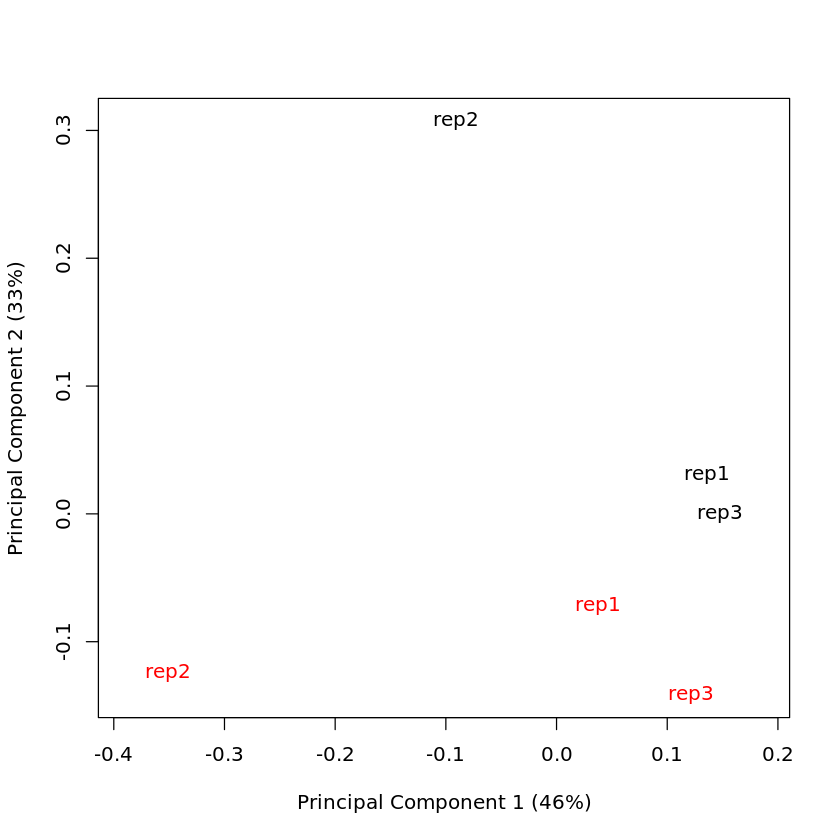

In [215]:
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",3), rep("red",3)),3)
plotMDS(
    ESETs$kg1, labels = pData(ESETs$kg1)[, 'reps'], 
    col=col_by_cond, 
    gene.selection = "common"
)

### molm14

In [197]:
%%R 
# molm14 cell line
e <- eset[,meta$line == "molm14"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(molm14= condtreated - condDMSO,levels = d)
fit_molm14 <- e %>% run_norm %>% run_limma (d, cm)
res_molm14 <- get_res(fit_molm14,'molm14') 

#### PCA

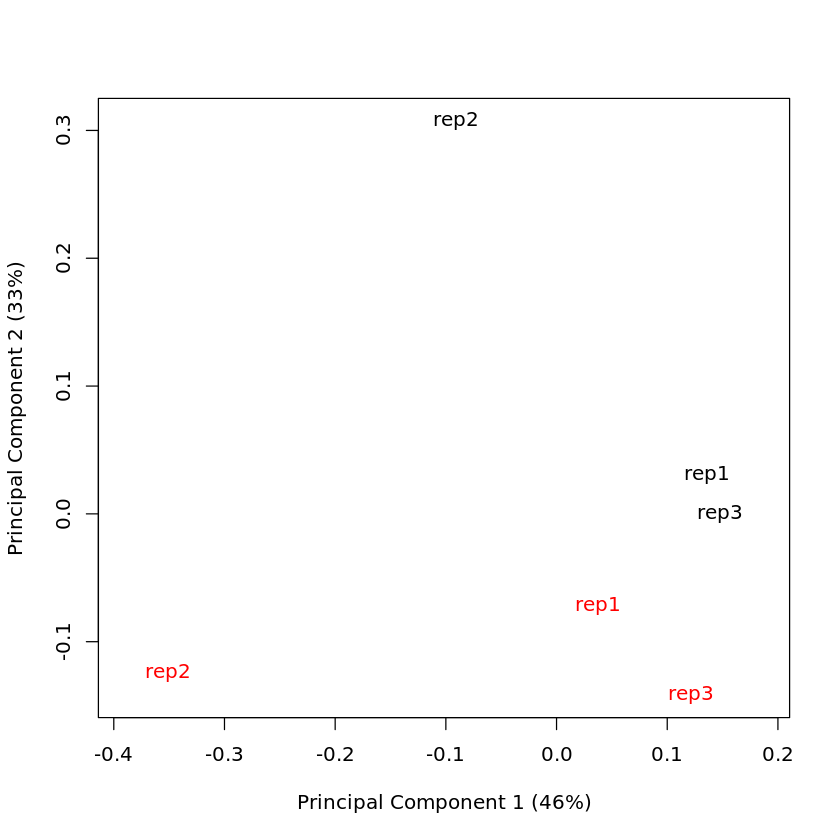

In [215]:
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",3), rep("red",3)),3)
plotMDS(
    ESETs$kg1, labels = pData(ESETs$kg1)[, 'reps'], 
    col=col_by_cond, 
    gene.selection = "common"
)

### ociaml2

In [203]:
# ociaml2 cell line
e <- eset[,meta$line == "ociaml2"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(ociaml2= condtreated - condDMSO,levels = d)
fit_ociaml2 <- e %>% run_norm %>% run_limma (d, cm)
res_ociaml2 <- get_res(fit_ociaml2,'ociaml2') 

#### PCA

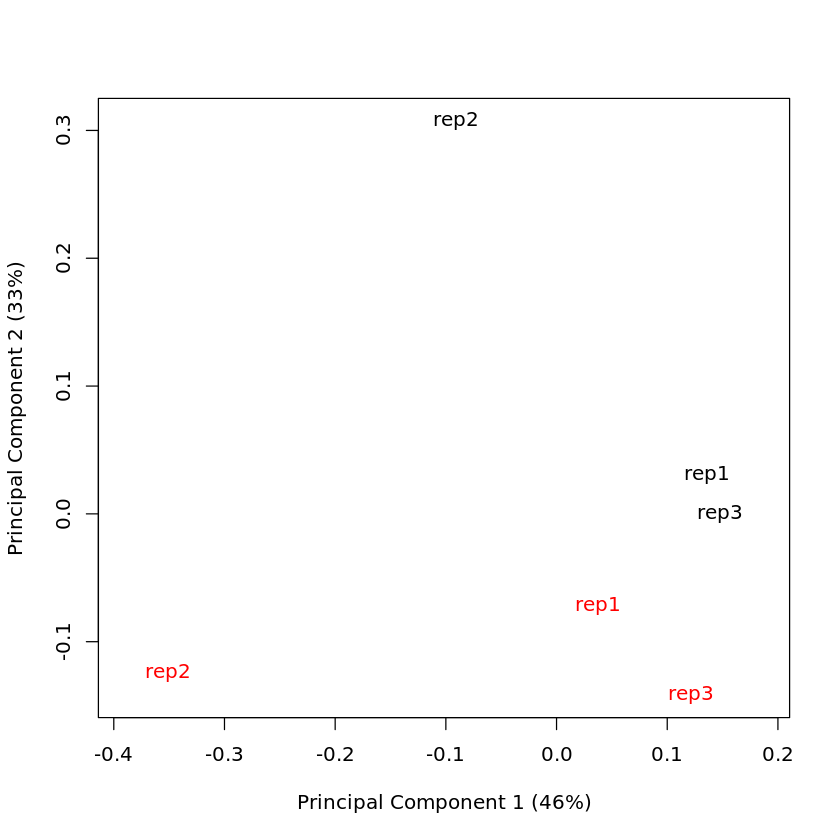

In [215]:
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",3), rep("red",3)),3)
plotMDS(
    ESETs$kg1, labels = pData(ESETs$kg1)[, 'reps'], 
    col=col_by_cond, 
    gene.selection = "common"
)

### ociaml3

In [204]:
# ociaml3 cell line
e <- eset[,meta$line == "ociaml3"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(ociaml3= condtreated - condDMSO,levels = d)
fit_ociaml3 <- e %>% run_norm %>% run_limma (d, cm)
res_ociaml3 <- get_res(fit_ociaml3,'ociaml3') 

#### PCA

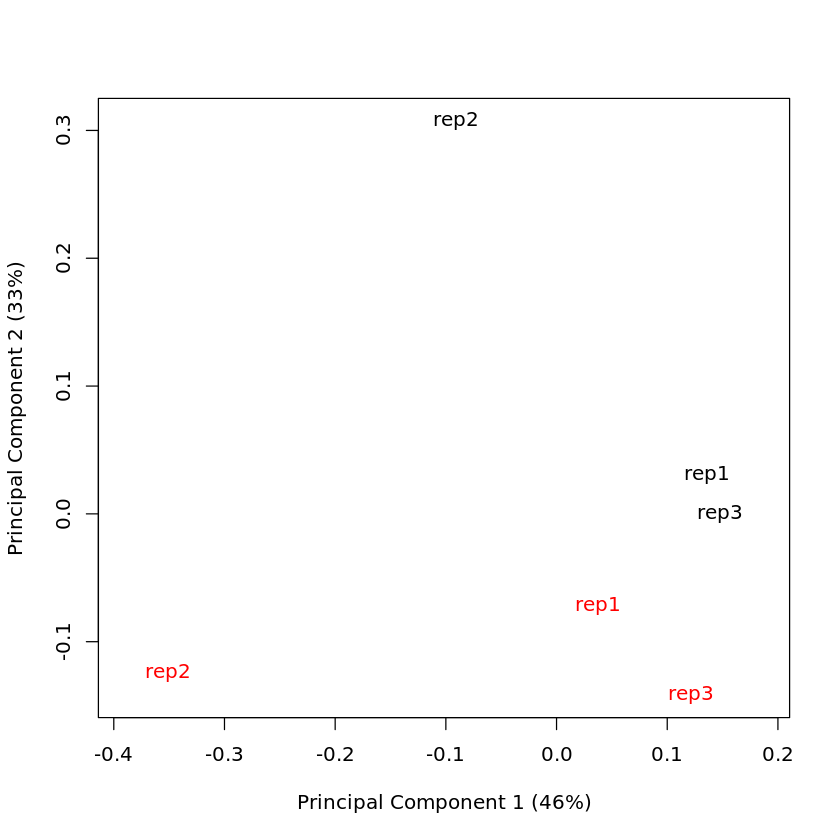

In [215]:
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",3), rep("red",3)),3)
plotMDS(
    ESETs$kg1, labels = pData(ESETs$kg1)[, 'reps'], 
    col=col_by_cond, 
    gene.selection = "common"
)

### thp1

In [206]:
# thp1 cell line
e <- eset[,meta$line == "thp1"]
d <- model.matrix(~0 + cond, pData(e))
# contrast design
cm <- makeContrasts(thp1= condtreated - condDMSO,levels = d)
fit_thp1 <- e %>% run_norm %>% run_limma (d, cm)
res_thp1 <- get_res(fit_thp1,'thp1') 

#### PCA

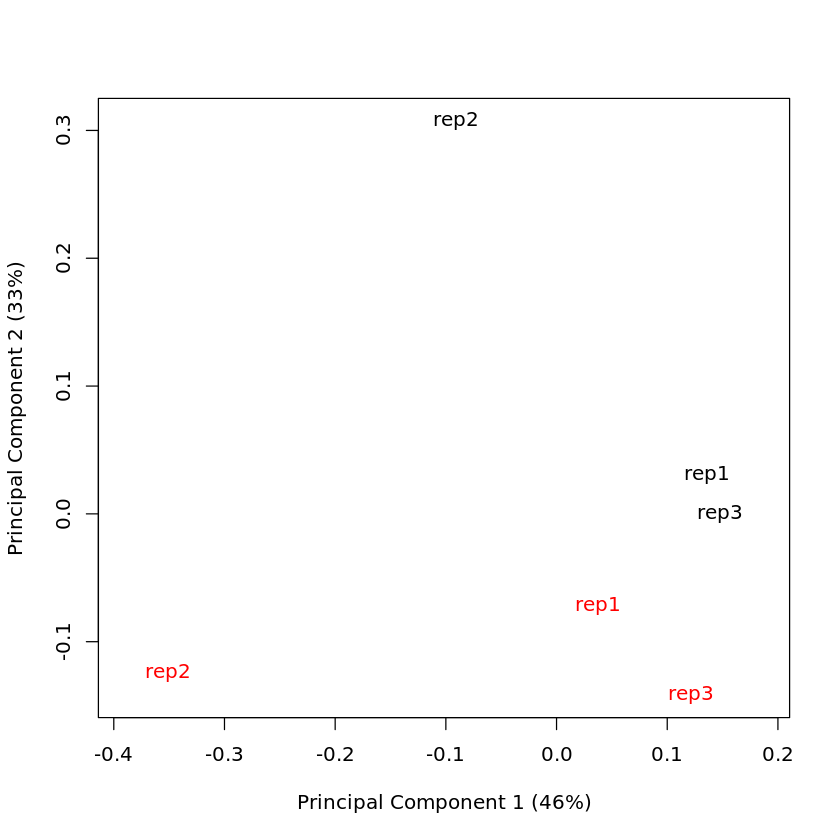

In [215]:
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",3), rep("red",3)),3)
plotMDS(
    ESETs$kg1, labels = pData(ESETs$kg1)[, 'reps'], 
    col=col_by_cond, 
    gene.selection = "common"
)

## Plots

### Correlation matrix

In [604]:
library(Hmisc)
library(corrplot)
library(pheatmap)
library(ggcorrplot)

In [514]:
all_fc <- result_table %>% select(ends_with("log2FC")) 
colnames(all_fc) <- colnames(all_fc) %>% stringr::str_remove(pattern = "_log2FC") %>% unlist


In [695]:
corr <- rcorr(
    as.matrix(
        all_fc %>% select('hl60_6h','hl60_72h','hl60_120h','kg1','molm14','ociaml2','ociaml3','thp1')
    )
)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



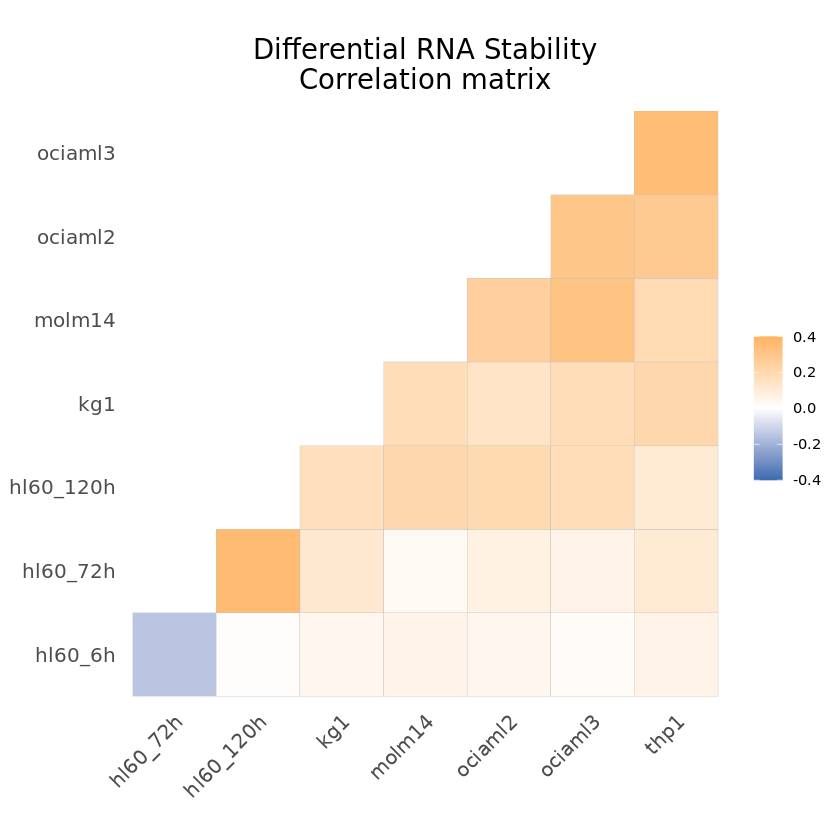

In [703]:
colors=c("#386cb0","white","#fdb462")
ggcorrplot(
    corr$r, 
    method = c("square", "circle"),
    hc.order = TRUE,
    type = "lower", p.mat = corr$p,
    
) + ggtitle(
    "Differential RNA Stability\nCorrelation matrix"
) + ggplot2::scale_fill_gradient2(
    low = colors[1], high = colors[3], mid = colors[2], 
    midpoint = 0, limit = c(-0.4, 0.4), space = "Lab"
) + theme(
    plot.title = element_text(
        # face = "bold",
        size = rel(1.5), hjust = 0.5),
    panel.background = element_blank(), 
    panel.border = element_blank(), 
    panel.grid.major = element_line(colour = "white"), 
    legend.title = element_blank(),
    # legend.position="bottom"
)

ggsave('stbl/plots/logFC_corr.pdf',width = 4, height = 4)

### Volcano Plots

In [228]:
%%R 
p1 = res_kg1 %>% 
plot_volcano (title='RNA Stability\nkg1 cell line')

p2 = res_molm14 %>% 
plot_volcano (title='molm14 cell line')

p3 = res_ociaml2 %>% 
plot_volcano (title='ociaml2 cell line')

p4 = res_ociaml3 %>% 
plot_volcano (title='ociaml3 cell line')

p5 = res_thp1 %>% 
plot_volcano (title='thp1 cell line')

p1$labels$x <- p2$labels$x <- p3$labels$x <- p4$labels$x <- " "


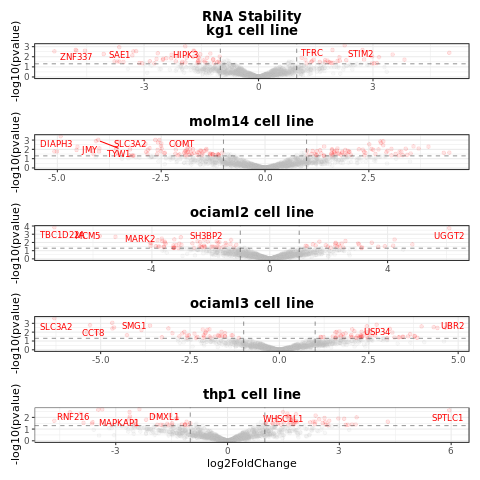

In [229]:
%%R 
(p1 / p2 / p3 / p4 / p5) + plot_layout(widths = c(1, 25))

In [ ]:
# # Plot principal components labeled by treatment
# col_by_cond=rep(c(rep("black",2), rep("red",2)),3)
# plotMDS(ESETs$hl60, labels = pData(ESETs$hl60)[, "time"], col=col_by_cond, gene.selection = "common")

In [196]:
# df_sig = results %>% rownames_to_column %>% 
#     filter (
#         hl60.72h.stbl.log2FoldChange > 1 & hl60.72h.stbl.pvalue < 0.05 
# #         P.Value_120h   < 0.001 |
# #         adj.P.Val_6h   < 0.05 
# #         adj.P.Val_120h < 0.05)
#            ) %>% 
#     remove_rownames %>% column_to_rownames('rowname') 

# df_sig %>% head

### Clustering 

In [704]:
library(RColorBrewer)

heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
greens <- brewer.pal(n = 9, name = "Greens")

### Heatmap to show HL-60 time series clusters

png 
  2

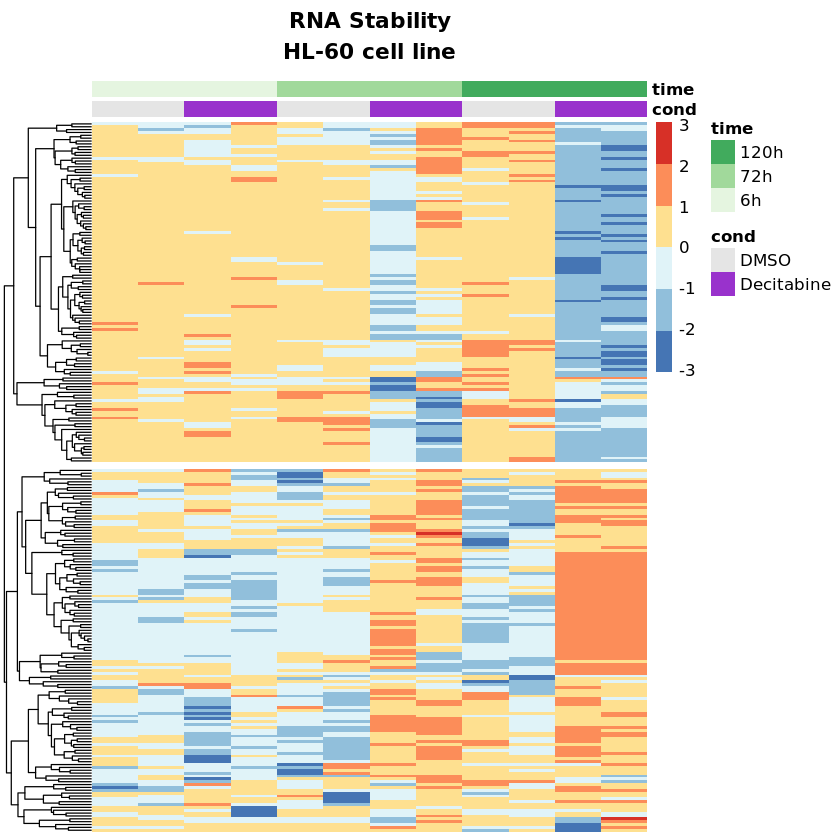

In [746]:
ann_colors = list(
    cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
    time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
)


exprs(eset)[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        filter(
            (abs(hl60_6h_log2FC)  > 0.5 & hl60_6h_pvalue   < 0.01) |
            (abs(hl60_72h_log2FC) > 0.5 & hl60_72h_pvalue  < 0.01)|
            (abs(hl60_120h_log2FC)> 0.5 & hl60_120h_pvalue < 0.01) 
        ) %>% 
        rownames
    , 
    # subset normalized counts
    colData[colData$line=='hl60',c('cond','time')] %>% arrange(time,cond) %>% rownames
] %>% data.frame %>% replace(is.na(.), 0) %>% 
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = F,
        cutree_rows = 2,
        main = 'RNA Stability\nHL-60 cell line',
        annotation = colData[colData$line=='hl60',c('cond','time')],
        cluster_cols = F, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_hl60

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('stbl/plots/heatmap_clustering_hl60.pdf', width=4, height=7)
grid::grid.newpage()
grid::grid.draw(hm_hl60$gtable)
dev.off()

### Heatmap to show cell line consistency 

### volcano plots

In [150]:
# p1 = res_6h %>% 
# plot_volcano (title='RNA Stability\nhl60 cell line treated for 6h\nnot normalized')

# p2 = res_norm_6h %>% 
# plot_volcano (title='normalized')

# p3 = res_120h %>% 
# plot_volcano (title='RNA Stability\nhl60 cell line treated for 120h\nnot normalized')

# p4 = res_norm_120h %>% 
# plot_volcano (title='normalized')

# (p1 / p2)

In [151]:
# %%R 
# (p3 / p4)

In [243]:
# p1 = res_72h %>% 
# plot_volcano (title='RNA Stability\nhl60 cell line treated for 72h\nnot normalized')

# p2 = res_norm_72h %>% 
# plot_volcano (title='')

# # p1 / 
# p2

In [244]:
# %%R 
# boxplot_top_hit(eset, 'USP3')

In [245]:
# boxplot_top_hit(ESETs$hl60 %>% run_norm, 'USP3')

___

## Enrichment analysis

Write iGET friendly tables:

In [685]:
for (name in names(results)){
    write.table(
        results[[name]][,c('name','log2FoldChange')],
        paste0('stbl/',name,'_delta_stbl.txt'), 
        quote = F, col.names=FALSE, row.names=FALSE,sep ='\t'
    )
}

#
___

In [170]:
%%R 
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12      RColorBrewer_1.1-2   patchwork_1.0.0     
 [4] ggrepel_0.8.1        forcats_0.4.0        stringr_1.4.0       
 [7] dplyr_0.8.3          purrr_0.3.3          readr_1.3.1         
[10] tidyr_1.0.0          tibble_2.1.3         ggplot2_3.2.1  

In [171]:
!date

Wed Nov 10 01:07:30 UTC 2021
